# Import data, python packages, and define customized functions

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd /content/drive/MyDrive/Carol_Copy/Dissertation/iDSP

/content/drive/MyDrive/Carol_Copy/Dissertation/iDSP


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import math
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from scipy.stats import kurtosis
from scipy.stats import skew

In [4]:
wftime = pd.read_csv("ProcessedData/time.csv")
wftrajc = pd.read_csv("ProcessedData/analyzed_trajectory.csv")

trial_info = pd.read_csv("trial_info.csv")
wf = wftrajc.merge(wftime[['ParticipantID','TrialNumber','Status','Time']], how = 'left', on = ['ParticipantID','TrialNumber'])\
            .merge(trial_info[['TrialID','min_grid_dis','learn_grid_dis']], how = 'left', left_on = 'TrialNumber', right_on = 'TrialID')\
            .drop(['TrialID'],axis=1)

def efficiency(x):
  if x['Status'] == 'Success' and x['grid_distance']+0.001 >= x['min_grid_dis']:
    return x['grid_distance']/x['min_grid_dis']
  elif x['Status'] == 'Success' and x['grid_distance']+0.001 < x['min_grid_dis']:
    return 1
  else: return np.nan

wf['efficiency']=wf.apply(efficiency, axis=1)
# wf['efficiency']= wf.efficiency.fillna(2.19)

In [5]:
sub_fail = wf.groupby(['ParticipantID']).apply(lambda x: (x['Status']!='Success').sum()).reset_index(name='total_failure')
sub_fail[sub_fail['total_failure']>int(24*0.3)]

,ParticipantID,total_failure


In [6]:
trial_fail = wf.groupby(['TrialNumber']).apply(lambda x: (x['Status']!='Success').sum()).reset_index(name='total_failure')
trial_fail[trial_fail['total_failure']>int(wf.ParticipantID.nunique()*0.2)]

,TrialNumber,total_failure


In [ ]:
wf[wf.Status=='Success'].shape[0]/wf.shape[0]

0.9453125

In [7]:
pp1 = pd.read_csv("ProcessedData/pointingPhase1.csv")
pp2 = pd.read_csv("ProcessedData/pointingPhase2.csv")

pp1_sub = pp1.groupby('ID')['AngErrorAbs'].mean().reset_index().\
              rename(columns={'ID':'ParticipantID','AngErrorAbs':'Point_PreError'})
pp2_sub = pp2.groupby('ID')['AngErrorAbs'].mean().reset_index().\
              rename(columns={'ID':'ParticipantID','AngErrorAbs':'Point_PostError'})
wf_sub = wf.groupby('ParticipantID')[['efficiency','Time']].mean().reset_index()
wf_sub_f_c = wf.groupby('ParticipantID')['Status'].apply(lambda x: 24-sum(x=='Success'))
from functools import reduce
sub_performance = reduce(lambda x,y: pd.merge(x,y, on='ParticipantID', how='outer'), [pp1_sub,pp2_sub,wf_sub,wf_sub_f_c]).dropna()
sub_performance.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48 entries, 0 to 49
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ParticipantID    48 non-null     int64  
 1   Point_PreError   48 non-null     float64
 2   Point_PostError  48 non-null     float64
 3   efficiency       48 non-null     float64
 4   Time             48 non-null     float64
 5   Status           48 non-null     float64
dtypes: float64(5), int64(1)
memory usage: 2.6 KB


In [8]:
def pearsonr_ci(x,y,alpha=0.05):
    ''' calculate Pearson correlation along with the confidence interval using scipy and numpy
    Parameters
    ----------
    x, y : iterable object such as a list or np.array
      Input for correlation calculation
    alpha : float
      Significance level. 0.05 by default
    Returns
    -------
    r : float
      Pearson's correlation coefficient
    pval : float
      The corresponding p value
    lo, hi : float
      The lower and upper bound of confidence intervals
    '''

    r, p = stats.pearsonr(x,y)
    r_z = np.arctanh(r)
    se = 1/np.sqrt(x.size-3)
    z = stats.norm.ppf(1-alpha/2)
    lo_z, hi_z = r_z-z*se, r_z+z*se
    lo, hi = np.tanh((lo_z, hi_z))
    return r, p, lo, hi

def bi_pr_test(r_c,N):
  df = N-2
  t_value = r_c * np.sqrt(df) / np.sqrt(1-r_c**2)
  p_value = stats.t.sf(abs(t_value), df)*2  # two-sided pvalue = Prob(abs(t)>tt)
  z_u = np.log((1+r_c)/(1-r_c))/2 + 1.96*np.sqrt(1/(N-3))
  z_l = np.log((1+r_c)/(1-r_c))/2 - 1.96*np.sqrt(1/(N-3))
  r_u = (np.exp(2*z_u)-1)/(np.exp(2*z_u)+1)
  r_l = (np.exp(2*z_l)-1)/(np.exp(2*z_l)+1)
  print('t-statistic = %5.3f pvalue = %6.4f df = %2.0f' % (t_value,p_value,df))
  print('95CI = [%4.2f, %4.2f]' % (r_l,r_u))

def CI_conhen(var,mu):
  print("95% Confidence Interval: {}".format(stats.t.interval(0.95, var.size - 1, var.mean(), stats.sem(var))))
  cohen_d = ( var.mean() - mu )/var.std()
  print("cohen_d {}".format(round(cohen_d,2)))

# Overall Performance and Reliability

In [9]:
round(sub_performance[['Point_PreError','efficiency','Point_PostError']].describe().transpose(),2)

,count,mean,std,min,25%,50%,75%,max
Point_PreError,48.0,64.58,27.45,8.21,46.98,73.23,84.41,102.97
efficiency,48.0,1.54,0.40,1.04,1.22,1.44,1.74,2.58
Point_PostError,48.0,52.90,28.11,12.49,26.65,48.70,80.40,99.97


In [ ]:
print("Skewness for three measures")
print(np.round(skew(sub_performance[['Point_PreError','efficiency','Point_PostError']]),2))
print("Kurtosis for three measures")
print(np.round(kurtosis(sub_performance[['Point_PreError','efficiency','Point_PostError']]),2))

Skewness for three measures
[-0.67  0.61  0.07]
Kurtosis for three measures
[-0.69 -0.48 -1.46]


In [ ]:
print("Point Phase I differ from 90")
print(stats.ttest_1samp(sub_performance['Point_PreError'], popmean = 90))
print("Point Phase I CI")
CI_conhen(sub_performance['Point_PreError'],90)
print("Efficiency differ from 2.19")
print(stats.ttest_1samp(sub_performance['efficiency'], popmean = 2.19))
print("Efficiency CI")
CI_conhen(sub_performance['efficiency'], 2.19)

Point Phase I differ from 90
Ttest_1sampResult(statistic=-6.416044829884999, pvalue=6.296797479836112e-08)
Point Phase I CI
95% Confidence Interval: (56.60513909734849, 72.5480687773043)
cohen_d -0.93
Efficiency differ from 2.19
Ttest_1sampResult(statistic=-10.993841508287176, pvalue=1.3781323711563338e-14)
Efficiency CI
95% Confidence Interval: (1.4506013420071646, 1.6793459274520353)
cohen_d -1.59


In [ ]:
# !pip install rpy2==3.5.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 201 kB 4.9 MB/s 
  Created wheel for rpy2: filename=rpy2-3.5.1-cp38-cp38-linux_x86_64.whl size=310195 sha256=041e37aef93d769713841ae00efce623fd8a0508b98285555632294090560867
  Stored in directory: /root/.cache/pip/wheels/6b/40/7d/f63e87fd83e8b99ee837c8e3489081c4b3489134bc520235ed
Successfully built rpy2
  Attempting uninstall: rpy2
    Found existing installation: rpy2 3.5.5
    Uninstalling rpy2-3.5.5:
      Successfully uninstalled rpy2-3.5.5


In [ ]:
%load_ext rpy2.ipython

In [ ]:
%%R
install.packages("splithalf")
library("splithalf")

(as ‘lib’ is unspecified)
































































	‘/tmp/RtmpXBbZZ1/downloaded_packages’








In [ ]:
valid_pp1 = pp1.loc[pp1.ID.isin(sub_performance.ParticipantID.to_list()),:]

In [ ]:
%%R -i valid_pp1
set.seed(123)
splithalf(data=valid_pp1,
          outcome = "accuracy",
          score = "average",
          halftype = "random",
          permutations = 5000,
          var.ACC = "AngErrorAbs",
          var.participant = "ID",
          average="mean")

  |======================================================================| 100%[1] "condition all complete"
[1] "Calculating split half estimates"
[1] "split half estimates for 5000 random splits"
  condition  n spearmanbrown SB_low SB_high
1       all 48          0.87   0.81    0.92
[1] "this could be reported as: using 5000 random splits, the spearman-brown corrected reliability  estimate for the all condition was 0.87, 95% CI [0.81, 0.92]"


In [ ]:
valid_pp2 = pp2.loc[pp2.ID.isin(sub_performance.ParticipantID.to_list()),:]

In [ ]:
%%R -i valid_pp2
set.seed(123)
splithalf(data=valid_pp2,
          outcome = "accuracy",
          score = "average",
          halftype = "random",
          permutations = 5000,
          var.ACC = "AngErrorAbs",
          var.participant = "ID",
          average="mean")

  |======================================================================| 100%[1] "condition all complete"
[1] "Calculating split half estimates"
[1] "split half estimates for 5000 random splits"
  condition  n spearmanbrown SB_low SB_high
1       all 48           0.9   0.85    0.94
[1] "this could be reported as: using 5000 random splits, the spearman-brown corrected reliability  estimate for the all condition was 0.9, 95% CI [0.85, 0.94]"


In [ ]:
valid_wf = wf.loc[wf.ParticipantID.isin(sub_performance.ParticipantID.to_list()),:]

In [ ]:
%%R -i valid_wf
set.seed(123)
splithalf(data=wf,
          outcome = "accuracy",
          score = "average",
          halftype = "random",
          permutations = 5000,
          var.ACC = "efficiency",
          var.participant = "ParticipantID",
          average="mean")

  |======================================================================| 100%[1] "condition all complete"
[1] "Calculating split half estimates"
[1] "split half estimates for 5000 random splits"
  condition  n spearmanbrown SB_low SB_high
1       all 48          0.87   0.79    0.92
[1] "this could be reported as: using 5000 random splits, the spearman-brown corrected reliability  estimate for the all condition was 0.87, 95% CI [0.79, 0.92]"


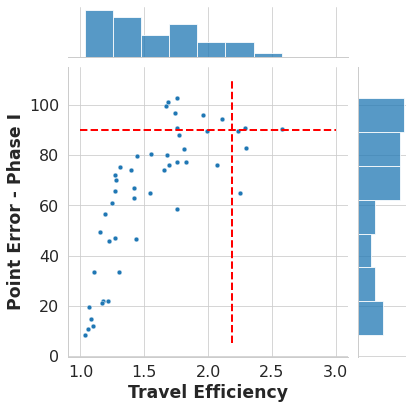

In [ ]:
sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.8)
g = sns.jointplot(data=sub_performance, y="Point_PreError", x="efficiency")
g.ax_joint.set_ylabel('Point Error - Phase I', fontweight='bold')
g.ax_joint.set_xlabel('Travel Efficiency', fontweight='bold')
g.ax_joint.plot([1,3], [90,90], 'r--', linewidth = 2)
g.ax_joint.plot([2.19,2.19],[5,110] , 'r--', linewidth = 2)
plt.show()

In [ ]:
round(sub_performance[['efficiency','Point_PreError','Point_PostError']].corr(),2)

,efficiency,Point_PreError,Point_PostError
efficiency,1.00,0.74,0.79
Point_PreError,0.74,1.00,0.78
Point_PostError,0.79,0.78,1.00


In [ ]:
pearsonr_ci(sub_performance['efficiency'],sub_performance['Point_PreError'])

(0.7441982632716697,
 1.342701201594951e-09,
 0.5834316812609254,
 0.8488429549619136)

In [ ]:
sub_performance[['efficiency','Point_PreError','Point_PostError']].corr()

,efficiency,Point_PreError,Point_PostError
efficiency,1.000000,0.744198,0.792307
Point_PreError,0.744198,1.000000,0.776632
Point_PostError,0.792307,0.776632,1.000000


In [ ]:
#Travel Efficiency - SplitHalf:0.87
print(round(0.744198/math.sqrt(0.87*0.87),2))
print(round(0.792307/math.sqrt(0.87*0.90),2))
print(round(0.776632/math.sqrt(0.87*0.90),2))

0.86
0.9
0.88


# K-mean Clustering

In [10]:
sc = StandardScaler()
X = sc.fit_transform(sub_performance[['Point_PreError','Point_PostError','efficiency']])
# X = sc.fit_transform(sub_performance[['Point_PreError','efficiency']])

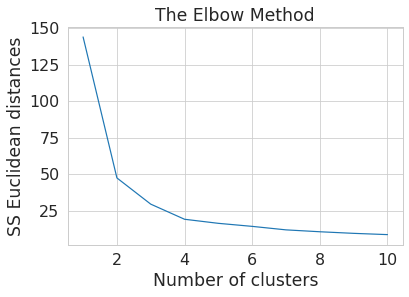

In [11]:
sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.8)
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('SS Euclidean distances')
plt.show()

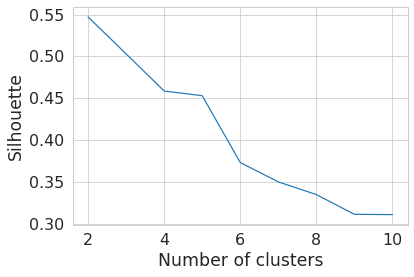

In [12]:
silhouette_coefficients = []
for k in range(2, 11):
  kmeans = KMeans(n_clusters=k, init = 'k-means++', random_state = 42)
  kmeans.fit(X)
  score = silhouette_score(X,kmeans.labels_)
  silhouette_coefficients.append(score)
plt.plot(range(2, 11), silhouette_coefficients)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette')
plt.show()

In [13]:
kmeans = KMeans(n_clusters = 2, init = 'k-means++', random_state = 42)
y_kmeans = kmeans.fit_predict(X)
print("low spatial: {}".format(sum(y_kmeans == 0)))
print("high spatial: {}".format(sum(y_kmeans == 1)))

low spatial: 24
high spatial: 24


In [14]:
sub_performance['high_spatial']=y_kmeans
iVR_l = sub_performance[sub_performance.high_spatial==0]
iVR_h = sub_performance[sub_performance.high_spatial==1]

# High / Low Spatial Groups Performance and Reliability

In [15]:
pd.set_option('display.max_columns',500)
round(sub_performance.groupby('high_spatial')[['Point_PreError','efficiency','Point_PostError','Status']].describe(),2)

Point_PreError                                                   \
                      count   mean    std    min    25%   50%    75%     max   
high_spatial                                                                   
0                      24.0  44.02  23.09   8.21  21.81  46.9  65.03   75.34   
1                      24.0  85.14  11.16  58.77  77.49  85.7  91.95  102.97   

             efficiency                                            \
                  count  mean   std   min   25%   50%   75%   max   
high_spatial                                                        
0                  24.0  1.22  0.12  1.04  1.13  1.22  1.27  1.49   
1                  24.0  1.85  0.31  1.44  1.65  1.75  2.06  2.58   

             Point_PostError                                                   \
                       count   mean    std    min    25%    50%    75%    max   
high_spatial                                                                    
0                       24.0  28.27  12.04  12.49  17.42  26.64  36.64  51.07   
1                       24.0  77.54  14.25  45.35  70.45  80.55  85.05  99.97   

             Status                                         
              count  mean   std  min   25%  50%   75%  max  
high_spatial                                                
0              24.0  0.54  0.88  0.0  0.00  0.0  1.00  3.0  
1              24.0  2.08  1.93  0.0  0.75  2.0  3.25  7.0

In [16]:
stats.ttest_ind(iVR_l.Status, iVR_h.Status)

Ttest_indResult(statistic=-3.5553206744756625, pvalue=0.0008870396338062972)

In [17]:
round(sub_performance.groupby('high_spatial')[['Point_PreError','efficiency','Point_PostError']].agg({skew,kurtosis}),2)

Point_PreError          efficiency          Point_PostError  \
                       skew kurtosis       skew kurtosis            skew   
high_spatial                                                               
0                     -0.17    -1.46       0.55    -0.43            0.41   
1                     -0.42    -0.24       0.65    -0.52           -0.70   

                       
             kurtosis  
high_spatial           
0               -1.09  
1               -0.09

In [ ]:
print("Point Phase I differ from 90")
print(stats.ttest_1samp(iVR_l['Point_PreError'], popmean = 90))
print("Point Phase I CI")
CI_conhen(iVR_l['Point_PreError'],90)
print("Efficiency differ from 2.19")
print(stats.ttest_1samp(iVR_l['efficiency'], popmean = 2.19))
print("Efficiency CI")
CI_conhen(iVR_l['efficiency'], 2.19)

Point Phase I differ from 90
Ttest_1sampResult(statistic=-2.1347354735016917, pvalue=0.04366177172019303)
Point Phase I CI
95% Confidence Interval: (80.42281610313346, 89.84944547568598)
cohen_d -0.44
Efficiency differ from 2.19
Ttest_1sampResult(statistic=-5.249898843654918, pvalue=2.5150006033022204e-05)
Efficiency CI
95% Confidence Interval: (1.771620923814893, 2.0081383478237296)
cohen_d -1.07


In [ ]:
pp_l = valid_pp1[valid_pp1.ID.isin(iVR_l.ParticipantID.to_list())]
pp_h = valid_pp1[valid_pp1.ID.isin(iVR_h.ParticipantID.to_list())]
pp2_l = valid_pp2[valid_pp2.ID.isin(iVR_l.ParticipantID.to_list())]
pp2_h = valid_pp2[valid_pp2.ID.isin(iVR_h.ParticipantID.to_list())]
wf_l = valid_wf[valid_wf.ParticipantID.isin(iVR_l.ParticipantID.to_list())]
wf_h = valid_wf[valid_wf.ParticipantID.isin(iVR_h.ParticipantID.to_list())]

In [ ]:
%%R -i pp_l
set.seed(123)
splithalf(data=pp_l,
          outcome = "accuracy",
          score = "average",
          halftype = "random",
          permutations = 5000,
          var.ACC = "AngErrorAbs",
          var.participant = "ID",
          average="mean")

  |======================================================================| 100%[1] "condition all complete"
[1] "Calculating split half estimates"
[1] "split half estimates for 5000 random splits"
  condition  n spearmanbrown SB_low SB_high
1       all 24          0.12  -0.33    0.55
[1] "this could be reported as: using 5000 random splits, the spearman-brown corrected reliability  estimate for the all condition was 0.12, 95% CI [-0.33, 0.55]"


In [ ]:
%%R -i pp_h
set.seed(123)
splithalf(data=pp_h,
          outcome = "accuracy",
          score = "average",
          halftype = "random",
          permutations = 5000,
          var.ACC = "AngErrorAbs",
          var.participant = "ID",
          average="mean")

  |======================================================================| 100%[1] "condition all complete"
[1] "Calculating split half estimates"
[1] "split half estimates for 5000 random splits"
  condition  n spearmanbrown SB_low SB_high
1       all 24          0.85   0.73    0.93
[1] "this could be reported as: using 5000 random splits, the spearman-brown corrected reliability  estimate for the all condition was 0.85, 95% CI [0.73, 0.93]"


In [ ]:
%%R -i wf_l
set.seed(123)
splithalf(data=wf_l,
          outcome = "accuracy",
          score = "average",
          halftype = "random",
          permutations = 5000,
          var.ACC = "efficiency",
          var.participant = "ParticipantID",
          average="mean")

  |======================================================================| 100%[1] "condition all complete"
[1] "Calculating split half estimates"
[1] "split half estimates for 5000 random splits"
  condition  n spearmanbrown SB_low SB_high
1       all 24          0.57   0.26     0.8
[1] "this could be reported as: using 5000 random splits, the spearman-brown corrected reliability  estimate for the all condition was 0.57, 95% CI [0.26, 0.8]"


In [ ]:
%%R -i wf_h
set.seed(123)
splithalf(data=wf_h,
          outcome = "accuracy",
          score = "average",
          halftype = "random",
          permutations = 5000,
          var.ACC = "efficiency",
          var.participant = "ParticipantID",
          average="mean")

  |======================================================================| 100%[1] "condition all complete"
[1] "Calculating split half estimates"
[1] "split half estimates for 5000 random splits"
  condition  n spearmanbrown SB_low SB_high
1       all 24          0.57    0.3    0.78
[1] "this could be reported as: using 5000 random splits, the spearman-brown corrected reliability  estimate for the all condition was 0.57, 95% CI [0.3, 0.78]"


In [ ]:
%%R -i pp2_l
set.seed(123)
splithalf(data=pp2_l,
          outcome = "accuracy",
          score = "average",
          halftype = "random",
          permutations = 5000,
          var.ACC = "AngErrorAbs",
          var.participant = "ID",
          average="mean")

  |======================================================================| 100%[1] "condition all complete"
[1] "Calculating split half estimates"
[1] "split half estimates for 5000 random splits"
  condition  n spearmanbrown SB_low SB_high
1       all 24          0.47   0.14    0.73
[1] "this could be reported as: using 5000 random splits, the spearman-brown corrected reliability  estimate for the all condition was 0.47, 95% CI [0.14, 0.73]"


In [ ]:
%%R -i pp2_h
set.seed(123)
splithalf(data=pp2_h,
          outcome = "accuracy",
          score = "average",
          halftype = "random",
          permutations = 5000,
          var.ACC = "AngErrorAbs",
          var.participant = "ID",
          average="mean")

  |======================================================================| 100%[1] "condition all complete"
[1] "Calculating split half estimates"
[1] "split half estimates for 5000 random splits"
  condition  n spearmanbrown SB_low SB_high
1       all 24          0.62   0.33    0.82
[1] "this could be reported as: using 5000 random splits, the spearman-brown corrected reliability  estimate for the all condition was 0.62, 95% CI [0.33, 0.82]"


In [18]:
round(iVR_l[['efficiency','Point_PreError','Point_PostError']].corr(),2)

,efficiency,Point_PreError,Point_PostError
efficiency,1.00,0.71,0.53
Point_PreError,0.71,1.00,0.66
Point_PostError,0.53,0.66,1.00


In [19]:
iVR_l[['efficiency','Point_PreError','Point_PostError']].corr()

,efficiency,Point_PreError,Point_PostError
efficiency,1.00000,0.709020,0.530450
Point_PreError,0.70902,1.000000,0.658136
Point_PostError,0.53045,0.658136,1.000000


In [ ]:
#Travel Efficiency - SplitHalf:0.57
print(0.049569/math.sqrt(0.12*0.57))
print(0.081216/math.sqrt(0.57*0.47))
print(-0.096606/math.sqrt(0.12*0.47))
print("low Spatial: Efficiency vs. Phase I")
print(pearsonr_ci(iVR_l.efficiency,iVR_l.Point_PreError))

0.18953180853716461
0.15691166807776713
-0.4067846424327607
low Spatial: Efficiency vs. Phase I
(0.0495694083108813, 0.8180786594309541, -0.3610468433097824, 0.4440861116902404)


In [ ]:
bi_pr_test(0.049569,24)

t-statistic = 0.233 pvalue = 0.8181 df = 22
95CI = [-0.36, 0.44]


In [ ]:
bi_pr_test(0.4067846424327607,24)

t-statistic = 2.089 pvalue = 0.0485 df = 22
95CI = [0.00, 0.70]


In [20]:
iVR_h[['efficiency','Point_PreError','Point_PostError']].corr()

,efficiency,Point_PreError,Point_PostError
efficiency,1.000000,0.070303,0.092404
Point_PreError,0.070303,1.000000,-0.096606
Point_PostError,0.092404,-0.096606,1.000000


In [ ]:
pearsonr_ci(iVR_h.efficiency,iVR_h.Point_PreError)

(0.7518594612352683,
 2.2740870600112864e-05,
 0.5001601371145538,
 0.8864100891955956)

In [ ]:
bi_pr_test(0.751859,24)

t-statistic = 5.349 pvalue = 0.0000 df = 22
95CI = [0.50, 0.89]


In [ ]:
bi_pr_test(0.550753,24)

t-statistic = 3.095 pvalue = 0.0053 df = 22
95CI = [0.19, 0.78]


In [ ]:
bi_pr_test(0.658136,24)

t-statistic = 4.100 pvalue = 0.0005 df = 22
95CI = [0.35, 0.84]


In [ ]:
#Travel Efficiency - SplitHalf:0.57
print(0.751859/math.sqrt(0.85*0.57))
print(0.550753/math.sqrt(0.57*0.62))
print(0.658136/math.sqrt(0.85*0.62))

1.0801635352631938
0.9264534414022226
0.9065887796362962


In [ ]:
ivrl = pearsonr_ci(iVR_l['efficiency'],iVR_l['Point_PreError'])
ivrh = pearsonr_ci(iVR_h['efficiency'],iVR_h['Point_PreError'])

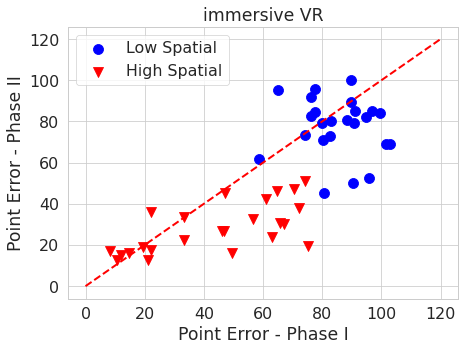

In [ ]:
sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.8)
fig, ax = plt.subplots(figsize = (7,5))
plt.scatter(iVR_l['Point_PreError'], iVR_l['Point_PostError'], s = 100, c = 'blue', label = 'Low Spatial')
plt.scatter(iVR_h['Point_PreError'], iVR_h['Point_PostError'], s = 100, c = 'red',marker="v", label = 'High Spatial')
# plt.scatter(kmeans.cluster_centers_[:, 2], kmeans.cluster_centers_[:, 0], s = 300, c = 'yellow', label = 'Centroids')
plt.title('immersive VR')
plt.xlabel('Point Error - Phase I')
plt.ylabel('Point Error - Phase II')
plt.plot([0,120], [0,120], 'r--', linewidth = 2)
plt.legend()
plt.show()

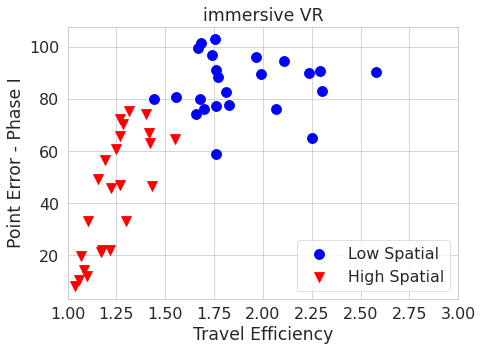

In [ ]:
sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.8)
fig, ax = plt.subplots(figsize = (7,5))
plt.scatter(iVR_l['efficiency'], iVR_l['Point_PreError'], s = 100, c = 'blue', label = 'Low Spatial')
plt.scatter(iVR_h['efficiency'], iVR_h['Point_PreError'], s = 100, c = 'red',marker="v", label = 'High Spatial')
# plt.scatter(kmeans.cluster_centers_[:, 2], kmeans.cluster_centers_[:, 0], s = 300, c = 'yellow', label = 'Centroids')
plt.title('immersive VR')
plt.ylabel('Point Error - Phase I')
plt.xlabel('Travel Efficiency')
plt.xlim(1.0,3)
plt.legend()
plt.show()

# Compare with the Desktop Version

In [ ]:
df_dt = pd.read_csv('Desktop_Performance.csv')

In [ ]:
df_dt.head()

,Subject,Point_PreError,Point_PostError,efficiency,Time,low_spatial
0,605,83.037037,46.333333,1.424865,14.947368,0
1,606,55.814815,69.407407,1.605543,17.105263,0
2,607,89.000000,101.259259,1.997710,24.263158,1
3,608,102.666667,85.925926,1.746614,19.473684,1
4,609,36.814815,29.259259,1.172134,11.526316,0


In [ ]:
df_dt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57 entries, 0 to 56
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Subject          57 non-null     int64  
 1   Point_PreError   57 non-null     float64
 2   Point_PostError  57 non-null     float64
 3   efficiency       57 non-null     float64
 4   Time             57 non-null     float64
 5   low_spatial      57 non-null     int64  
dtypes: float64(4), int64(2)
memory usage: 2.8 KB


In [ ]:
dVR_l = df_dt[df_dt.low_spatial==1]
dVR_h = df_dt[df_dt.low_spatial==0]
dvrl = pearsonr_ci(dVR_l['efficiency'],dVR_l['Point_PreError'])
dvrh = pearsonr_ci(dVR_h['efficiency'],dVR_h['Point_PreError'])

In [ ]:
rdf = pd.DataFrame([ivrl,ivrh,dvrl,dvrh], columns=['r', 'p', 'ci_l','ci_h'])

In [ ]:
rdf['interface']=['iVR','iVR','Desktop','Desktop']
rdf['Spatial']  = ['low','high','low','high']
rdf['ci'] = rdf.apply(lambda x: [x['r']-x['ci_l'],x['ci_h']-x['r']],axis=1)
rdf

,r,p,ci_l,ci_h,interface,Spatial,ci
0,0.032302,0.880893,-0.375994,0.430094,iVR,low,"[0.40829610702886965, 0.39779235862742685]"
1,0.751859,0.000023,0.500160,0.886410,iVR,high,"[0.2516993241207145, 0.13455062796032735]"
2,0.003823,0.982082,-0.320593,0.327437,Desktop,low,"[0.324416164832746, 0.3236133409089278]"
3,0.635684,0.002593,0.268769,0.841491,Desktop,high,"[0.3669152159291701, 0.20580662629983604]"


In [ ]:
rdf_p = rdf.pivot("interface", "Spatial", ["r","ci"])

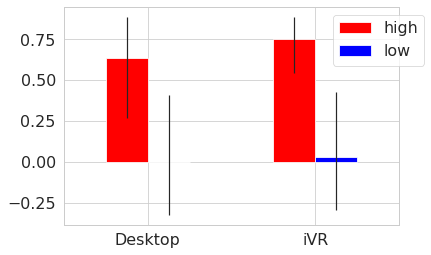

In [ ]:
sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.8)
rdf_p.plot(kind='bar',y='r',yerr = 'ci',color=['red', 'blue'])
# plt.errorbar(x = rdf_p.index,y=rdf_p['r'],yerr = rdf_p['ci_l'], fmt='.k')
plt.legend(bbox_to_anchor=(1.1, 1))
plt.xticks(rotation=0)
plt.xlabel("")
plt.show()